# Proyect Drones

by: Maximo Jara

This notebook attempts to reveal and process the data available for the Drones Experiment in Athens.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from dateutil import parser
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import time
import os
import math
from os import listdir
from os.path import isfile, join
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
import sys
import csv
import geopy
from geopy.distance import VincentyDistance
import geopandas as gpd
maxInt = sys.maxsize  # to read problematic csv files with various numbers of columns
decrement = True

## Input Files

The following code imports the files and exports them in different csv files per vehicle. Needs to Run just once, after, files are exported and can be used independently.

In [2]:
path_input_trajectory_data = '{}/Data/maximo.csv'.format(os.path.dirname(os.path.abspath('Data')))        # csv file
path_to_export = '{}/Data/Trajectories_big/'.format(os.path.dirname(os.path.abspath('Data')))      # folder

In [ ]:
start = time.time()
def data_parser(path_trajectory_data):
    csv.field_size_limit(sys.maxsize)
    data_file = open(path_trajectory_data, 'r')
    data_reader = csv.reader(data_file)
    data = []
    for row in data_reader:
        data.append([elem for elem in row[0].split("; ")])
    return data

def create_new_trajectory_data_frame():
    headings_names = ['Tracked Vehicle', 'Type', 'Entry Gate', 'Entry Time[ms]', 'Exit Gate', 'Exit Time[ms]', 'Traveled Dist.[m]',  'Avg.Speed[km / h]',
                      'Latitude [deg]', 'Longitude [deg]', 'Speed[km / h]', 'Tan.Accel.[ms - 2]', 'Lat.Accel.[ms - 2]', 'Time[ms]']
    new_df = pd.DataFrame(columns=headings_names)
    return new_df, headings_names

trajectory_data_array = data_parser(path_input_trajectory_data)
new_trajectory, column_names = create_new_trajectory_data_frame()
tracked_vehicle_id = 0

for tracked_vehicle_id in range(1, len(trajectory_data_array)):
    print('Tracked Vehicle: ', tracked_vehicle_id)
    print(trajectory_data_array[tracked_vehicle_id][1])
    new_trajectory.at[0, column_names[0]] = trajectory_data_array[tracked_vehicle_id][0]  # 0: Tracked Vehicle
    new_trajectory.at[0, column_names[1]] = trajectory_data_array[tracked_vehicle_id][1]  # 1: Type
    new_trajectory.at[0, column_names[2]] = trajectory_data_array[tracked_vehicle_id][2]  # 2: Entry Gate
    new_trajectory.at[0, column_names[3]] = trajectory_data_array[tracked_vehicle_id][3]  # 3: Entry Time [ms]
    new_trajectory.at[0, column_names[4]] = trajectory_data_array[tracked_vehicle_id][4]  # 4: Exit Gate
    new_trajectory.at[0, column_names[5]] = trajectory_data_array[tracked_vehicle_id][5]  # 5: Exit Time [ms]
    new_trajectory.at[0, column_names[6]] = trajectory_data_array[tracked_vehicle_id][6]  # 6: Traveled Dist. [m]
    new_trajectory.at[0, column_names[7]] = trajectory_data_array[tracked_vehicle_id][7]  # 7: Avg. Speed [km/h]
    for j in range(8, len(trajectory_data_array[tracked_vehicle_id]), 6):
        try:
            new_trajectory.at[divmod(j, 6)[0] - 1, column_names[8]] = trajectory_data_array[tracked_vehicle_id][j]          # 8: Latitude [deg]
            new_trajectory.at[divmod(j, 6)[0] - 1, column_names[8 + 1]] = trajectory_data_array[tracked_vehicle_id][j + 1]  # 9: Longitude [deg]
            new_trajectory.at[divmod(j, 6)[0] - 1, column_names[8 + 2]] = trajectory_data_array[tracked_vehicle_id][j + 2]  # 10: Speed [km/h]
            new_trajectory.at[divmod(j, 6)[0] - 1, column_names[8 + 3]] = trajectory_data_array[tracked_vehicle_id][j + 3]  # 11: Tan. Accel. [ms-2]
            new_trajectory.at[divmod(j, 6)[0] - 1, column_names[8 + 4]] = trajectory_data_array[tracked_vehicle_id][j + 4]  # 12: Lat. Accel. [ms-2]
            new_trajectory.at[divmod(j, 6)[0] - 1, column_names[8 + 5]] = trajectory_data_array[tracked_vehicle_id][j + 5]  # 13: Time [ms]
        except IndexError:
            continue

    new_trajectory.to_csv(path_to_export + 'trajectory' + str(tracked_vehicle_id) + '.csv', index=False)
    new_trajectory, column_names = create_new_trajectory_data_frame()

end = time.time()
print()
print()
print('Time for extracting ' + str(tracked_vehicle_id) + ' vehicles was ' + str(int(divmod(end - start, 60)[0])) + ' minutes and ' +
      str(int(divmod(end - start, 60)[1])) + ' seconds.')
print()

## Bus Trajectories

Filter for all Bus Trajectories, and store them as a list of data frames called `bus_files`

In [3]:
file_names = []
for file in os.listdir(path_to_export):
    if file.endswith(".csv"):
        file_names.append(file)
        
speed_limit = 5
bus_files = [] 
for i in range(len(file_names)):
    traj = pd.read_csv(str(path_to_export)+'/'+ str(file_names[i]))
    if traj.Type[0] == 'Bus':
        traj['BusStop_Flag'] = traj.apply(lambda row: 1 if row['Speed[km / h]'] < speed_limit else 0, axis = 1 )
        bus_files.append(traj)
print('Number of Buses in data: {}'.format(len(bus_files)))

Number of Buses in data: 54


In [4]:
#Obtaining All Vehicles Coordinates
start = time.time()
for i in range(len(file_names)):
    traj = pd.read_csv(str(path_to_export)+'/'+ str(file_names[i]))
    traj[['Latitude [deg]','Longitude [deg]']].to_csv(r'Data/Export CSVs/Vehicle Coordinates/veh{}_{}_coords'.format(i,traj.Type[0]), index=False)
end = time.time()
print('Time was ' + str(int(divmod(end - start, 60)[0])) + ' minutes and ' +
      str(int(divmod(end - start, 60)[1])) + ' seconds.')

Time was 0 minutes and 47 seconds.


## Input Parameters

Select and customize parameters to alter results.

In [27]:
rad = 10 # Input of radius for geofence in meters
lane_width = 3.5 #meters
#t_stop_min = 20000 # Minimum Stop Time at Bus Stops [ms]
bus_stops = pd.DataFrame({'Latitude':[37.991586, 37.9912586] , 'Longitude':[23.733125, 23.7337452] , 'Description': ['North', 'South']})

function to return time in mm:ss from ms

In [6]:
def time_to_min(ms): #turns time in ms to mm:ss
    import time
    time_min = time.strftime('%M:%S', time.gmtime(ms/1000))
            
    return time_min

## Geofence around Bus Stop

The following code returns a list of coordinates describing a circular geofence around the provided bus stop coordinates and radius.

In [7]:
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

proj_wgs84 = pyproj.Proj(init='epsg:4326')


def geodesic_point_buffer(lat, lon, meters):
    # Azimuthal equidistant projection
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(meters)  # distance in metres
    return transform(project, buf).exterior.coords[:]

geofences = {}
for i in range(len(bus_stops)):
    coor_list = geodesic_point_buffer(bus_stops.Latitude[i], bus_stops.Longitude[i], rad)
    coor = pd.DataFrame(coor_list, columns = ['longitude', 'latitude'])
    geofences['Stop_{}'.format(i)]= Polygon(coor_list)
    coor.to_csv(r'Data/Export CSVs/geofence_coords_Stop{}'.format(i), index=False)

Check if the measurement of the Bus was inside the determined Geofence

In [8]:
#Method to check if inside Geofence
def check_in_geofence(geofence,lat,long):
    point = Point(long,lat) # create point. Has to be (LONGITUDE, LATITUDE)
#     print(geofence.contains(point)) # check if polygon contains point
#     print(point.within(geofence)) # check if a point is in the polygon 
    return point.within(geofence)

## Azimuth Computation

Determine bus Azimuth's in order to know which direction they are going (which Bus Stop applies to them)

In [9]:
geod = pyproj.Geod(ellps='WGS84')
#For a Specific Bus, Average Azimuth
# lat0, lon0 = bus_files[0]['Latitude [deg]'][0], bus_files[0]['Longitude [deg]'][0]
# lat1, lon1 = bus_files[0]['Latitude [deg]'][len(bus_files[0])-5], bus_files[0]['Longitude [deg]'][len(bus_files[0])-5]
    
lat0, lon0 = 37.990982,23.736429
lat1, lon1 = 37.990983,23.736423000000002

azimuth1, azimuth2, distance = geod.inv(lon0, lat0, lon1, lat1)
print('The distance is: {} meters'.format(distance))
print('    The Azimuth is: {} degrees'.format(azimuth1))

The distance is: 0.5386201588318648 meters
    The Azimuth is: -78.10754547048865 degrees


#### ---------------------------------------------------------------------------------------------------
# Micro Data Analysis (Single Bus)

Closer analysis to the trajectory of a single bus

In [11]:
bus_i = int(input('Enter the bus id desired (from 0 to {}): '.format(len(bus_files)))) # Number ID of Bus that wants to be analyzed
selected_bus = bus_files[bus_i]
for i in range(len(bus_stops)):
    selected_bus['{}_Flag'.format(list(geofences.keys())[i])] = selected_bus.apply(lambda row: 1 if check_in_geofence(geofences[list(geofences.keys())[i]],row['Latitude [deg]'],row['Longitude [deg]']) is True else 0, axis = 1)

# selected_bus['Time[min]'] = selected_bus.apply(lambda row: time_to_min(row['Time[ms]']), axis = 1)

Enter the bus id desired (from 0 to 54): 7


Save latitude and longitude data into a csv file in order to easily view the trajectory in https://www.gpsvisualizer.com/map?uploaded_file_1=&format=leaflet&convert_format=&form=leaflet&google_api_key=

In [ ]:
selected_bus[['Latitude [deg]','Longitude [deg]']].to_csv(r'Data/Export CSVs/bus{}_coords'.format(bus_i), index=False)

Plot selected bus trajectory, showing the threshold criteria for 'stop' and the corresponding flag

(0, 1.25)

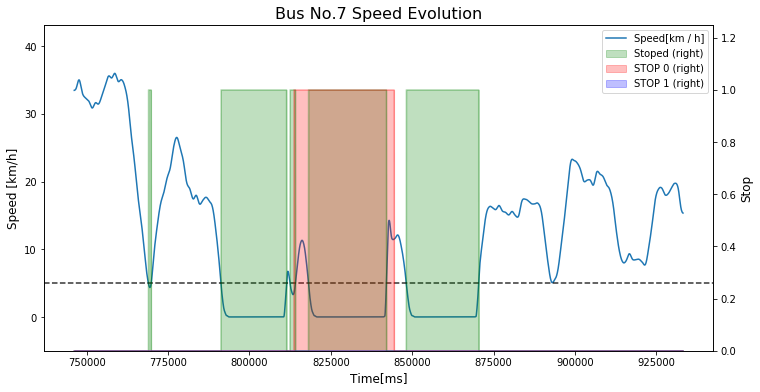

In [12]:
fig = plt.figure(figsize=(12,6)) #Figure size
ax = fig.add_subplot(111)

#Plotting Bus Speed Evolution
selected_bus.plot(x = 'Time[ms]', y = 'Speed[km / h]', kind = 'line', ax = ax)
ax.axhline(y = speed_limit, color = 'black', ls = '--', alpha = 0.8) #Speed Limit
ax.set_title('Bus No.{} Speed Evolution'.format(bus_i), fontsize = 16)
ax.set_ylabel('Speed [km/h]', fontsize = 12)
ax.set_xlabel('Measurement No.', fontsize = 12)

#Plotting Stop Flag as a Green Area
ax2 = selected_bus.plot.area(x = 'Time[ms]', y = 'BusStop_Flag', color = 'g', secondary_y = True, ax=ax, alpha = 0.25, label = 'Stoped')
ax2.set_ylabel('Stop', fontsize = 12)

#Plotting Geofence Flag as a Red Area
ax3 = selected_bus.plot.area(x = 'Time[ms]', y = 'Stop_0_Flag', color = 'r', secondary_y = True, ax=ax, alpha = 0.25, label = 'STOP 0')

#Plotting Geofence Flag as a Red Area
ax4 = selected_bus.plot.area(x = 'Time[ms]', y = 'Stop_1_Flag', color = 'b', secondary_y = True, ax=ax, alpha = 0.25, label = 'STOP 1')

#Setting Y limits
max_val = selected_bus['Speed[km / h]'].max()
ax.set_ylim(-5,max_val*1.2)
ax2.set_ylim(0,1.25)
ax3.set_ylim(0,1.25)
ax4.set_ylim(0,1.25)

In [ ]:
fig.savefig(r'Data/Plots/Trajectory_Bus_{}.jpeg'.format(bus_i), bbox_inches='tight')

#### --------------------------------------------------------------------------------------------------------------
# Macro Data Analysis

Iterate through each stop of each bus, and determine if the stop was inside a Geofence

In [13]:
all_info = []

#This For loops create a flag for Both bus Stops if the bus enters the geofence, for ALL Buses.
for k in range(len(bus_files)):
    for m in range(len(bus_stops)):
        stop_id = '{}_Flag'.format(list(geofences.keys())[m]) 
        bus_files[k][stop_id] = bus_files[k].apply(lambda row: 1 if check_in_geofence(geofences[list(geofences.keys())[m]],row['Latitude [deg]'],row['Longitude [deg]']) is True else 0, axis = 1)

#This Loop retreives information about each Stop of each bus to determine if they stopped inside a Geofence
for k in range(len(bus_files)):
    if bus_files[k]['BusStop_Flag'][0] == 1:
        start = 0
        beg_i = 0
    for i in range(1,len(bus_files[k])):            
        if bus_files[k]['BusStop_Flag'][i] == 1 and bus_files[k]['BusStop_Flag'][i-1] == 0:
            start = bus_files[k]['Time[ms]'][i]
            beg_pos = (bus_files[k]['Latitude [deg]'][i], bus_files[k]['Longitude [deg]'][i])
            beg_i = i

        elif bus_files[k]['BusStop_Flag'][i] == 0 and bus_files[k]['BusStop_Flag'][i-1] == 1:
            end = bus_files[k]['Time[ms]'][i-1]
            duration = end - start
            exit_pos = (bus_files[k]['Latitude [deg]'][i-1], bus_files[k]['Longitude [deg]'][i-1])
            exit_i = i
            azimuth1, azimuth2, distance = geod.inv(beg_pos[1],beg_pos[0],exit_pos[1] ,exit_pos[0] )
            valid_ratio_0 = sum(1 if x == 1 else 0 for x in bus_files[k].loc[beg_i:exit_i, 'Stop_0_Flag']) / bus_files[k].loc[beg_i:exit_i, 'Stop_0_Flag'].count()
            valid_ratio_1 = sum(1 if x == 1 else 0 for x in bus_files[k].loc[beg_i:exit_i, 'Stop_1_Flag']) / bus_files[k].loc[beg_i:exit_i, 'Stop_1_Flag'].count()

#             if duration >= t_stop_min:
#                 valid = 1
#             else:
#                 valid = 0
            all_info.append([k ,start, end , duration, azimuth1, valid_ratio_0, valid_ratio_1,beg_i,exit_i])

stops = pd.DataFrame(all_info, columns = ['Bus ID','Stop Start Time [ms]','Stop End Time [ms]', 'Duration [ms]', 'Azimuth', 'In Stop 0', 'In Stop 1','Start_i','End_i'])
#stops = stops.set_index('Bus ID')

From the Stops at the Geofences, discard those that happened further away from the lane width (other lane)

In [14]:
#Storing in different DF the stops inside Geofences
stops_in_0 = stops[['Bus ID','Stop Start Time [ms]','Stop End Time [ms]', 'Duration [ms]', 'Azimuth']][stops['In Stop 0']!=0].reset_index(drop=True)
stops_in_1 = stops[['Bus ID','Stop Start Time [ms]','Stop End Time [ms]', 'Duration [ms]', 'Azimuth']][stops['In Stop 1']!=0].reset_index(drop=True)
stops01 = [stops_in_0, stops_in_1]

#Loop to compute the distances of each bus that stopped inside the geofence, to discared those who stopped away from the right lane
d_df = {}
flag = ['Stop_0_Flag', 'Stop_1_Flag']
for i in range(len(stops01)):
    lat1 = bus_stops.loc[i][0] #latitude of Bus Stop
    lon1 = bus_stops.loc[i][1] #longitude of Bus Stop
    list_dist = []
    tag = flag[i]
    d_df['Distances_Stop_{}'.format(i)] = pd.DataFrame() 
    for k in range(len(stops01[i])): #Looping through all stops recorded at Bus Stop i
        id = int(stops01[i].loc[k]['Bus ID']) #Retreiveing bus ID to later use to find trajectory
        
        #For loop designed to retreive enter and exit measurement ids of bus trajectory
        for l in range(1,len(bus_files[id])):
            if bus_files[id][tag][0] == 1:
                beg_i = 0
            if bus_files[id][tag][l] == 1 and bus_files[id][tag][l-1] == 0:
                beg_i = l
            elif bus_files[id][tag][l] == 0 and bus_files[id][tag][l-1] == 1:
                exit_i = l
            
        pos_df = bus_files[id].loc[beg_i:exit_i,'Latitude [deg]':'Longitude [deg]'].reset_index(drop=True)
        distances = []
        for m in range(len(pos_df)):
            lat0 = pos_df.loc[m][0]
            lon0 = pos_df.loc[m][1]
            azimuth1, azimuth2, distance = geod.inv(lon0, lat0, lon1, lat1)
            distances.append(distance)
        d_df['Distances_Stop_{}'.format(i)].loc[:,'Bus {}'.format(id)] = pd.Series(distances)
        min_dist = min(distances)
        list_dist.append(round(min_dist,2))
    stops01[i]['Min Distance [m]'] = list_dist
    stops01[i]['Duration [ms]'] = stops01[i]['Duration [ms]']/1000
#     stops01[i]['Stop Start Time [ms]'] = stops01[i].apply(lambda x: time_to_min(x['Stop Start Time [ms]']), axis = 1)
#     stops01[i]['Stop End Time [ms]'] = stops01[i].apply(lambda row: time_to_min(row['Stop End Time [ms]']), axis = 1)
    stops01[i].columns = ['Bus ID', 'Stop Start Time [ms]', 'Stop End Time [ms]', 'Duration [s]','Azimuth', 'Min Distance [m]']
    stops01[i]['Valid'] = stops01[i].apply(lambda row: 1 if row['Min Distance [m]'] < lane_width else 0, axis = 1)

Plotting Distance Evolution to Stops 1 and 2

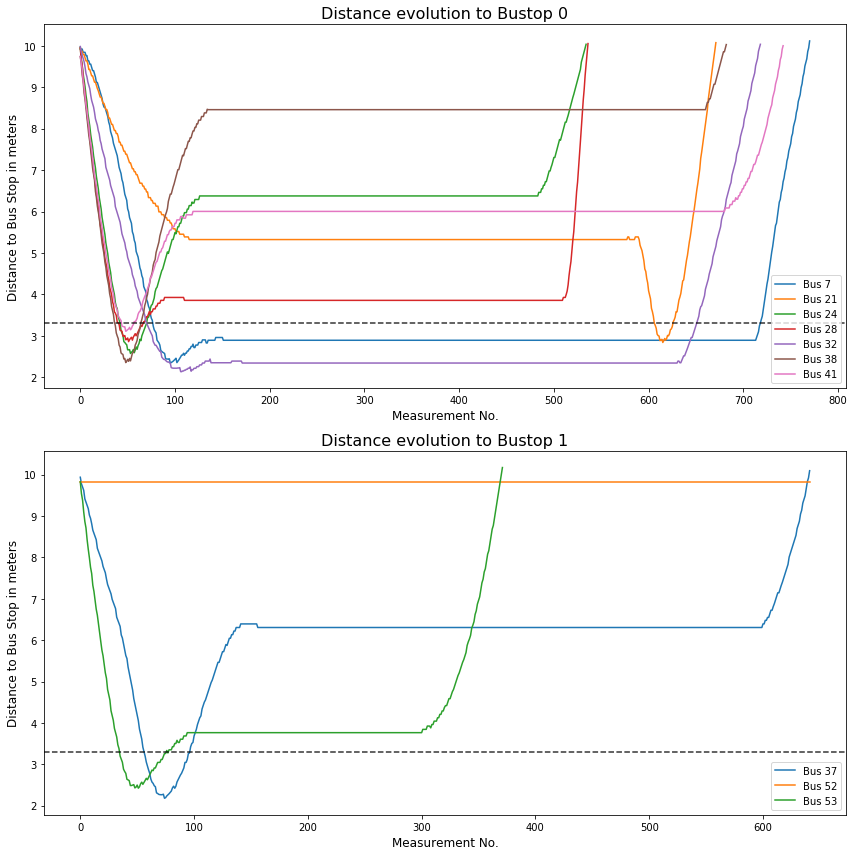

In [15]:
fig = plt.figure(figsize=(12,12)) #Figure size
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

d_df['Distances_Stop_0'].plot(kind = 'line', ax = ax) #To plot the distances measured of the bus to the bus Stop
ax.set_title('Distance evolution to Bustop 0', fontsize = 16)
ax.set_ylabel('Distance to Bus Stop in meters', fontsize = 12)
ax.set_xlabel('Measurement No.', fontsize = 12)
ax.axhline(y = lane_width, color = 'black', ls = '--', alpha = 0.8) #Lane Width
ax.legend(loc = 'lower right')

d_df['Distances_Stop_1'].plot(kind = 'line', ax = ax2) #To plot the distances measured of the bus to the bus Stop
ax2.set_title('Distance evolution to Bustop 1', fontsize = 16)
ax2.set_ylabel('Distance to Bus Stop in meters', fontsize = 12)
ax2.set_xlabel('Measurement No.', fontsize = 12)
ax2.axhline(y = lane_width, color = 'black', ls = '--', alpha = 0.8) #Lane Width
ax2.legend(loc = 'lower right')
fig.tight_layout()


In [ ]:
fig.savefig(r'Data/Plots/Distance_evolution_buses.jpeg', bbox_inches='tight')

In [ ]:
stops01[0]

#### ------------------------------------------------------------------------------------
# Effects of Stops on Traffic

In this section of the Notebook, we will analyze the effects of the Service-Related Stops in the downstream and upstream portion of the traffic

### Create Geofences Upstream and Downstream

Input Parameters

In [28]:
#Inputs for the Desired Stop to Study
bus_stop_id = 0 #In this case 0 for North or 1 for South
stop_i = 6 # index of stop event at the chosen bus stop
#Space and Time Conditions Inputs
az_street = -78.57968386288611 #degrees Azimuth of the street
dLu = 50 #[m] Distance upstream
dLd = 50 #[m] Distance downstream
dT = 20 #[s] Delta Time
n_lanes = 3
offset = lane_width /2
#Parameters for Data Analysis
t_inter = 5 #[s] to take measurements

Create method to return Geofences given the bus stop coordinate, street Azimuth, and delta L

In [29]:
#This Method Creates helps create fences Downstream
def coords_fence_downstream(bus_coords, az, dLd, width):
    lat1,lon1 = bus_coords
        #Get Second point
    origin = geopy.Point(lat1,lon1)
    pt2 = VincentyDistance(meters = dLd).destination(origin, az)
    lat2, lon2 = pt2.latitude, pt2.longitude
        #Get Third point
    pt3 = VincentyDistance(meters = width).destination(pt2, az-90)
    lat3, lon3 = pt3.latitude, pt3.longitude
        #Get Fourth point
    pt4 = VincentyDistance(meters = width).destination(origin, az-90)
    lat4, lon4 = pt4.latitude, pt4.longitude
        #Make DF of Coordinates
    lats = [lat1,lat2,lat3,lat4,lat1]
    longs = [lon1,lon2,lon3,lon4,lon1]
    coor_df = pd.DataFrame({'latitude': lats, 'longitude': longs})
    return lats, longs, coor_df

#This Method Creates helps create fences Upstream
def coords_fence_upstream(bus_coords, az, dLu, width):
    lat1,lon1 = bus_coords
        #Get Second point
    origin = geopy.Point(lat1,lon1)
    pt2 = VincentyDistance(meters = dLu).destination(origin, az+180)
    lat2, lon2 = pt2.latitude, pt2.longitude
        #Get Third point
    pt3 = VincentyDistance(meters = width).destination(pt2, az-90)
    lat3, lon3 = pt3.latitude, pt3.longitude
        #Get Fourth point
    pt4 = VincentyDistance(meters = width).destination(origin, az-90)
    lat4, lon4 = pt4.latitude, pt4.longitude
        #Make DF of Coordinates
    lats = [lat1,lat2,lat3,lat4,lat1]
    longs = [lon1,lon2,lon3,lon4,lon1]
    coor_df = pd.DataFrame({'latitude': lats, 'longitude': longs})
    return lats, longs, coor_df

#This method takes the method above + number oof lanes to compute the coordinates of a Geofence per lane both upstream and Downstream
def all_lanes(bus_coords, az, dLd, dLu, width,n_lanes):
    lats_d,longs_d,coor_df_d = coords_fence_downstream(bus_coords, az, dLd, width)
    lats_u,longs_u,coor_df_u = coords_fence_upstream(bus_coords, az, dLu, width)
    coor_dic = {'lane 1 Down': coor_df_d, 'lane 1 Up': coor_df_u}
    for i in range(n_lanes-1):
        start = lats_d[3],longs_d[3]
        lats_d,longs_d,_ = coords_fence_downstream(start, az, dLd, width)
        coor_dic['lane {} Down'.format(i+2)] = pd.DataFrame({'latitude': lats_d, 'longitude': longs_d})
    for i in range(n_lanes-1):
        start = lats_u[3],longs_u[3]
        lats_u,longs_u,_ = coords_fence_upstream(start, az, dLu, width)
        coor_dic['lane {} Up'.format(i+2)] = pd.DataFrame({'latitude': lats_u, 'longitude': longs_u})
    return coor_dic

#Creating the Physical Geofences 
#Starting with an offset (sidewalk)
bus_stop_loc = geopy.Point(bus_stops.loc[bus_stop_id][['Latitude','Longitude']])
beg_geo = VincentyDistance(meters = offset).destination(bus_stop_loc, az_street-90)
olat, olon = beg_geo.latitude, beg_geo.longitude

polygons = {}
coor_dic = all_lanes((olat, olon),az_street,dLd, dLu,lane_width,n_lanes)
for i in coor_dic:
    lat_point_list = coor_dic[i]['latitude'].tolist()
    lon_point_list = coor_dic[i]['longitude'].tolist()
    polygons['Geofence {}'.format(i)] = Polygon(zip(lon_point_list, lat_point_list))
    coor_dic[i].to_csv(r'Data/Export CSVs/geofence_coords_{}'.format(i), index=False)
    
#Creating a "Giant" Geofence that engloves all of the previously created geofences
g_lat,g_long,_ = coords_fence_upstream(bus_stops.loc[bus_stop_id][['Latitude','Longitude']], az_street, dLu, lane_width)
glats,glongs,giant_fence_coords = coords_fence_downstream((g_lat[1],g_long[1]), az_street, dLd+dLu, n_lanes*lane_width)
giant_fence = Polygon(zip(glongs, glats))
giant_fence_coords.to_csv(r'Data/Export CSVs/Giant_fence_coords', index=False)

Using the created Geofences, Separate and isolate the trajectories to be studied for a Certain stop `stop_i`(Chosen in Inputs) into a Dataframe called `df_study`. Filtering out Motorcycles as well.

In [30]:
#Identify the time interval of the chosen stop
time_start = stops01[bus_stop_id].iloc[stop_i]['Stop Start Time [ms]'] - dT*1000
time_end = stops01[bus_stop_id].iloc[stop_i]['Stop End Time [ms]'] + dT*1000
study_traj = []

#Filter out all vehicle trajectories that were not active during the time interval
#Also Filter Out Motorcycles
for i in range(len(file_names)):
    traj = pd.read_csv(str(path_to_export)+'/'+ str(file_names[i]))
    if traj.Type[0] != 'Motorcycle':
        if True in ((time_start <= traj['Time[ms]']) & (time_end >= traj['Time[ms]'])).unique():
            traj = traj[(time_start <= traj['Time[ms]']) & (time_end >= traj['Time[ms]'])]

            #From the new set of trajectories, filter out those which are not inside the "Giant" fence during the studied time interval
            traj['In Study Space'] = traj.apply(lambda row: 1 if check_in_geofence(giant_fence,row['Latitude [deg]'],row['Longitude [deg]']) is True else 0, axis = 1)
            if True in (traj['In Study Space'] == 1).unique():
                traj_in = traj[traj['In Study Space'] == 1]

                #To the set of trajectories that will be part of the study, flag their presence within each of the smaller geofences
                for m in range(len(polygons)):
                    lane_id = '{}'.format(list(polygons.keys())[m]) 
                    traj_in[lane_id] = traj_in.apply(lambda row: 1 if check_in_geofence(polygons[list(polygons.keys())[m]],row['Latitude [deg]'],row['Longitude [deg]']) is True else 0, axis = 1)

                study_traj.append(traj_in)
#One combined Dataframe for all the trajectories studied
df_study = pd.concat(study_traj)

Save latitude and longitude data into a csv file in order to easily view the trajectory in https://www.gpsvisualizer.com/map?uploaded_file_1=&format=leaflet&convert_format=&form=leaflet&google_api_key=

In [ ]:
study_traj[2][['Latitude [deg]','Longitude [deg]']].to_csv(r'Data/Export CSVs/Study Trajectories/traj2_coords', index=False)

Create a Density [veh/km] DataFrame with densities at each time interval of 40 ms for each Region (geofence): `study_density` And an additional DF with data for each time interval defined above (5 seconds): `density_discrete`

In [31]:
study_density = pd.DataFrame({'Time[ms]': list(range(int(time_start), int(time_end), 40))})
for m in range(len(polygons)):
    all_info = []
    lane_id = '{}'.format(list(polygons.keys())[m]) 
    for i in (range(int(time_start), int(time_end), 40)):
        df_i = df_study[(df_study['Time[ms]'] == i)&(df_study[lane_id] == 1)]
        veh = len(df_i)
        #av_speed = df_i['Speed[km / h]'].mean()
        all_info.append(veh)
    study_density['{}'.format(lane_id)]= all_info #Storing the number of vehicles at each time step
#    study_density['{}'.format(lane_id)]= study_density['{}'.format(lane_id)]/(dLd/1000) #Converting to [veh/km]

#Create desity_discrete DF which has the first values of density to give individual density values each t_inter seconds
study_density['Abs Time[s]']= study_density['Time[ms]']-time_start #Set Time Start at 0
study_density['Abs Time[s]'] = study_density.apply(lambda row: math.floor(row['Abs Time[s]']/(t_inter*1000))*t_inter, axis = 1)
study_density = study_density[['Time[ms]', 'Abs Time[s]', 'Geofence lane 1 Down', 'Geofence lane 1 Up',
       'Geofence lane 2 Down', 'Geofence lane 3 Down', 'Geofence lane 2 Up',
       'Geofence lane 3 Up']]

#Taking the first measurement at desiret time interval, for big time intervals, take the average. 
density_discrete = study_density.groupby('Abs Time[s]').agg('first') 
density_discrete = density_discrete.drop(columns = ['Time[ms]'])

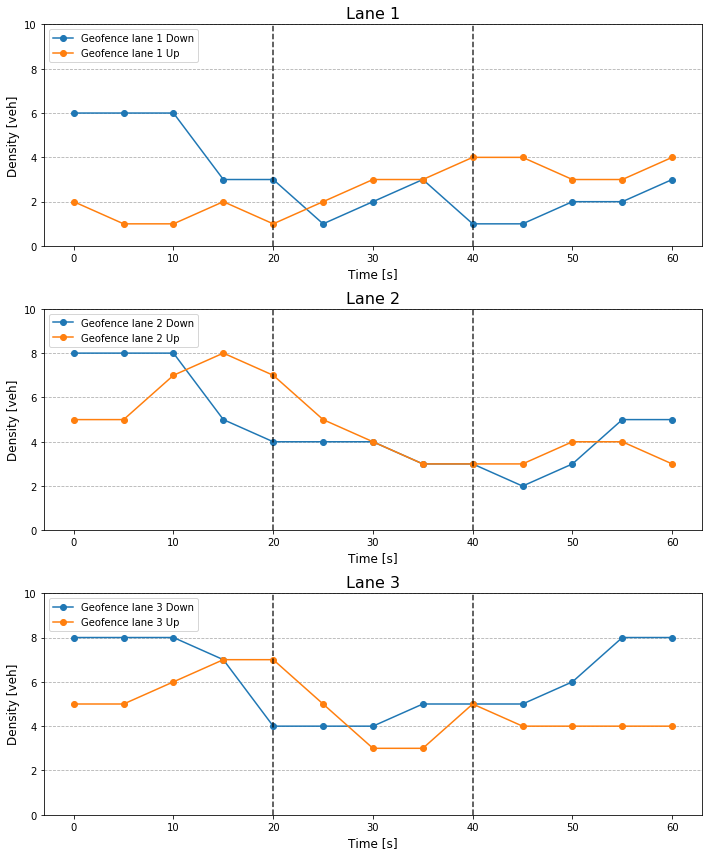

In [32]:
#Figure Parameters
fig = plt.figure(figsize=(10,12)) #Figure size

#Colors
color1, color2, color3 = '#FF5722','#FF9933','#333333'

#Plotting Lane 1
ax = fig.add_subplot(311)
density_discrete.plot(marker = 'o', y =['Geofence lane 1 Down','Geofence lane 1 Up'] ,ax = ax)
ax.axvline(x = dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax.axvline(x = density_discrete.index[-1]-dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax.set_title('Lane 1', fontsize = 16)
ax.set_ylabel('Density [veh]', fontsize = 12)
ax.set_xlabel('Time [s]', fontsize = 12)
ax.legend(loc = 'upper left')

#Plotting Lane 2
ax2 = fig.add_subplot(312)
density_discrete.plot(marker = 'o',y =['Geofence lane 2 Down','Geofence lane 2 Up'] ,ax = ax2)
ax2.axvline(x = dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax2.axvline(x = density_discrete.index[-1]-dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax2.set_title('Lane 2', fontsize = 16)
ax2.set_ylabel('Density [veh]', fontsize = 12)
ax2.set_xlabel('Time [s]', fontsize = 12)
ax2.legend(loc = 'upper left')

#Plotting Lane 3
ax3 = fig.add_subplot(313)
density_discrete.plot(marker = 'o',y =['Geofence lane 3 Down','Geofence lane 3 Up'] ,ax = ax3)
ax3.axvline(x = dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax3.axvline(x = density_discrete.index[-1]-dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax3.set_title('Lane 3', fontsize = 16)
ax3.set_ylabel('Density [veh]', fontsize = 12)
ax3.set_xlabel('Time [s]', fontsize = 12)
ax3.legend(loc = 'upper left')

#Setting Y limits
max_value = density_discrete.max().max()
ax.set_ylim(0,max_value+2)
ax2.set_ylim(0,max_value+2)
ax3.set_ylim(0,max_value+2)
[i.grid(axis = 'y', linestyle = '--')for i in [ax,ax2,ax3]]
fig.tight_layout()

In [33]:
time_to_min(time_start)

'12:48'

In [34]:
time_to_min(time_end)

'13:50'

Create a Flow [veh/h] DataFrame with flows at each time interval of 40 ms for each Region (geofence): `study_flow`  And an additional DF with data for each time interval defined above (5 seconds): `flow_discrete`

In [23]:
all_info = []
for traj in range(len(study_traj)):
    #Get the last values of Trajectories (Time and Fence Exit)
    time = study_traj[traj].iloc[-1]['Time[ms]']
    lane = (study_traj[traj].iloc[:,[15,16,17,18,19,20]].iloc[-1] == 1).argmax()
    all_info.append([time,lane,traj])
    for m in range(len(polygons)):
        lane_id = '{}'.format(list(polygons.keys())[m]) 
        for i in range(1, len(study_traj[traj])):
            if study_traj[traj][lane_id].iloc[i] == 0 and study_traj[traj][lane_id].iloc[i-1] == 1: #Vehicle exit
                time = study_traj[traj].iloc[i]['Time[ms]']
                lane = lane_id
                all_info.append([time,lane,traj])
        
exit_df = pd.DataFrame(all_info, columns = ['Time[ms]', 'Exit Lane','Trajectory Index'])
exit_df[exit_df['Time[ms]'] != time_end] #Discarding "EXITS" that where recorded because time stopped
#Create the DF study_flow full of zeros
study_flow = pd.DataFrame(np.zeros(study_density.shape))
study_flow[0] = list(range(int(time_start), int(time_end), 40))
study_flow.columns = study_density.columns

#Start populating the DF
for i in range(len(exit_df)):
    study_flow.loc[exit_df['Time[ms]'][i] == study_flow['Time[ms]'],exit_df.iloc[i]['Exit Lane']] += 1
    
#Create flow_discrete DF which has the summed values of flow to give individual flow values each t_inter seconds
study_flow['Abs Time[s]']= study_flow['Time[ms]']-time_start #Set Time Start at 0
study_flow['Abs Time[s]'] = study_flow.apply(lambda row: math.floor(row['Abs Time[s]']/(t_inter*1000))*t_inter, axis = 1)
study_flow = study_flow[['Time[ms]', 'Abs Time[s]', 'Geofence lane 1 Down', 'Geofence lane 1 Up',
       'Geofence lane 2 Down', 'Geofence lane 3 Down', 'Geofence lane 2 Up',
       'Geofence lane 3 Up']]

flow_discrete = study_flow.groupby('Abs Time[s]').agg('sum')
flow_discrete = flow_discrete.drop(columns = ['Time[ms]'])

Time series plot of Flow evolution

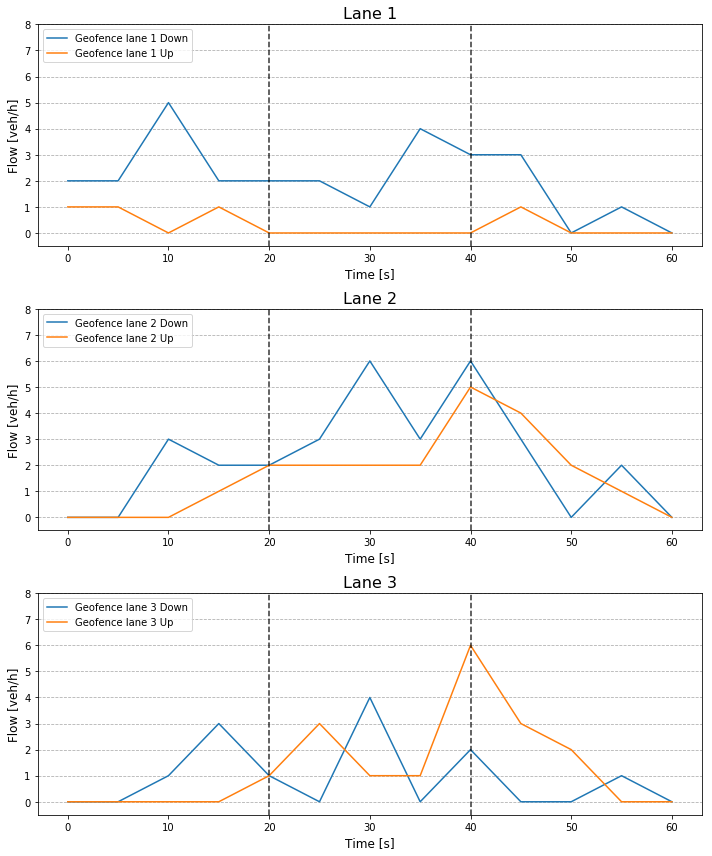

In [24]:
#Figure Parameters
fig = plt.figure(figsize=(10,12)) #Figure size

#Plotting Lane 1
ax = fig.add_subplot(311)
flow_discrete.plot(y =['Geofence lane 1 Down','Geofence lane 1 Up'] ,ax = ax)
ax.axvline(x = dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax.axvline(x = flow_discrete.index[-1]-dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax.set_title('Lane 1', fontsize = 16)
ax.set_ylabel('Flow [veh/h]', fontsize = 12)
ax.set_xlabel('Time [s]', fontsize = 12)
ax.legend(loc = 'upper left')

#Plotting Lane 2
ax2 = fig.add_subplot(312)
flow_discrete.plot(y =['Geofence lane 2 Down','Geofence lane 2 Up'] ,ax = ax2)
ax2.axvline(x = dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax2.axvline(x = flow_discrete.index[-1]-dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax2.set_title('Lane 2', fontsize = 16)
ax2.set_ylabel('Flow [veh/h]', fontsize = 12)
ax2.set_xlabel('Time [s]', fontsize = 12)
ax2.legend(loc = 'upper left')

#Plotting Lane 3
ax3 = fig.add_subplot(313)
flow_discrete.plot(y =['Geofence lane 3 Down','Geofence lane 3 Up'] ,ax = ax3)
ax3.axvline(x = dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax3.axvline(x = flow_discrete.index[-1]-dT, color = 'black', ls = '--', alpha = 0.8) #Bus Stop Starts
ax3.set_title('Lane 3', fontsize = 16)
ax3.set_ylabel('Flow [veh/h]', fontsize = 12)
ax3.set_xlabel('Time [s]', fontsize = 12)
ax3.legend(loc = 'upper left')

#Setting Y limits
max_value = flow_discrete.max().max()
ax.set_ylim(-0.5,max_value+2)
ax2.set_ylim(-0.5,max_value+2)
ax3.set_ylim(-0.5,max_value+2)
[i.grid(axis = 'y', linestyle = '--')for i in [ax,ax2,ax3]]
fig.tight_layout()

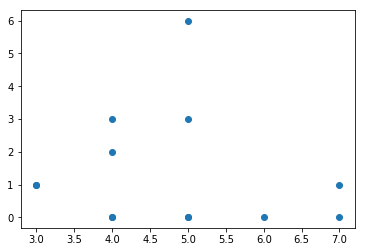

In [40]:
plt.scatter(density_discrete['Geofence lane 3 Up'],flow_discrete['Geofence lane 3 Up'])